#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.  
Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.  
Нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**План работ**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Содержание**<a id='toc0_'></a>    
- 1. [Подготовка](#toc1_)    
- 2. [Анализ](#toc2_)    
- 3. [Обучение](#toc3_)    
  - 3.1. [Линейная регрессия](#toc3_1_)    
  - 3.2. [Решающее дерево](#toc3_2_)    
  - 3.3. [Случайный лес](#toc3_3_)    
  - 3.4. [Градиентный бустинг](#toc3_4_)    
- 4. [Тестирование](#toc4_)    
- 5. [Общий вывод](#toc5_)    
- 6. [Чек-лист проверки](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Подготовка](#toc0_)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

Первоначально загрузим данные

In [2]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

Проверим, правильно ли отсортированы индексы

In [3]:
df.index.is_monotonic_increasing

True

Выполним ресемплинг данных, используя суммирование для агрегации значений

In [4]:
df = df.resample('1H').sum()

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Разделим данные на обучающую и тестовую выборки

In [8]:
train, test = train_test_split(df, test_size=0.1, shuffle=False, random_state=9349)

Для работы pipeline реализуем класс, создающий признаки: день, месяц, день недели, час, заданное количество лагов (предыдущих значений целевого признака), скользящее среднее. Возникшие пропуски заполняем медианой.

In [9]:
class TimeSeriesFeaturesMaker(BaseEstimator, TransformerMixin):
    def __init__(self, max_lag=1, rolling_mean_size=2):
        self.max_lag = max_lag
        self.rolling_mean_size = rolling_mean_size
        
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X, y=None):
        new_X = X.copy()
        new_X['month'] = X.index.month
        new_X['day'] = X.index.day
        new_X['dayofweek'] = X.index.dayofweek
        new_X['hour'] = X.index.hour
        
        for lag in range(1, self.max_lag+1):
            new_X[f'lag_{lag}'] = X.iloc[:, 0].shift(lag)
        
        new_X['rolling_mean'] = X.iloc[:, 0].shift().rolling(self.rolling_mean_size).mean()
        
        new_X = new_X.fillna(X.iloc[:, 0].median())\
                     .drop(X.columns[[0]], axis=1).dropna()
        return new_X

Для проверки правильности реализации класса `TimeSeriesFeaturesMaker` сравним его с другим методом предобработки - созданием признаков с помощью функции - на примере решающего дерева.

In [10]:
pipeline = Pipeline(steps=[
    ('features_maker', TimeSeriesFeaturesMaker(1, 2)),
    ('model', DecisionTreeRegressor(random_state=42))
])

pipeline.fit(df[:-1000], df[:-1000])
predictions = pipeline.predict(df[-1000:])
mse(df[-1000:], predictions)**0.5

48.10944813651472

In [11]:
def transform(X, max_lag, rolling_mean_size):
    new_X = X.copy()
    new_X['month'] = X.index.month
    new_X['day'] = X.index.day
    new_X['dayofweek'] = X.index.dayofweek
    new_X['hour'] = X.index.hour

    for lag in range(1, max_lag+1):
        new_X[f'lag_{lag}'] = X.iloc[:, 0].shift(lag)

    new_X['rolling_mean'] = X.iloc[:, 0].shift().rolling(rolling_mean_size).mean()

    new_X = new_X.fillna(X.iloc[:, 0].median())\
                 .drop(X.columns[[0]], axis=1).dropna()
    return new_X


model = DecisionTreeRegressor(random_state=42)
model.fit(transform(df[:-1000], 1, 2), df[:-1000])
predictions = model.predict(transform(df[-1000:], 1, 2))
mse(df[-1000:], predictions)**0.5

48.10944813651472

Значения метрик совпали - класс написан верно.

**Вывод по разделу 1:**

- Данные загружены, проведён ресемплинг по одному часу
- Датафрейм разбит на обучающую и тестовую выборки в соотношении 9:1
- Реализован и протестирован класс, создающий признаки для временного ряда

## 2. <a id='toc2_'></a>[Анализ](#toc0_)

Построим график временного ряда, а также скользящее среднее и скользящее СКО за каждые сутки

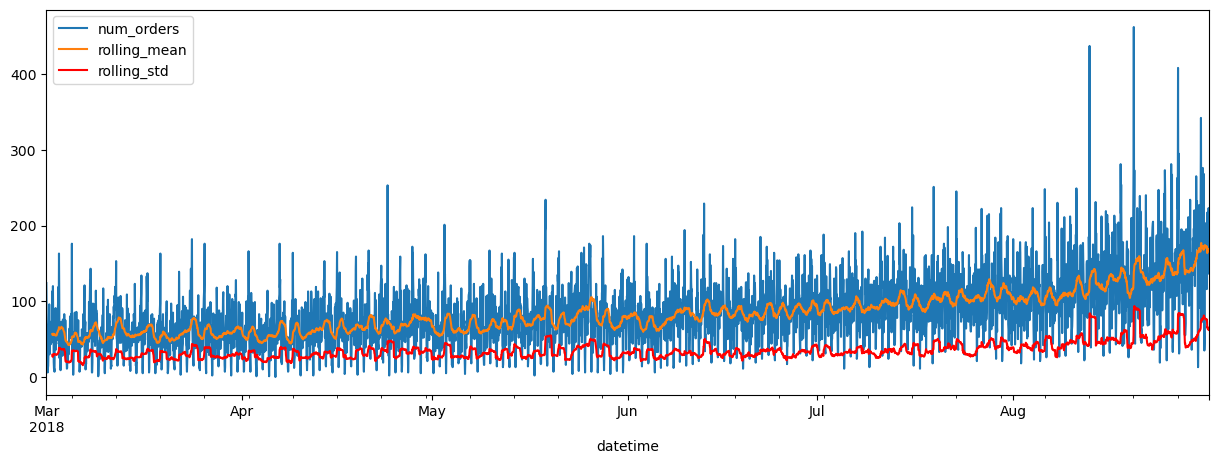

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
df.plot(ax=ax)
df.rolling(24).mean().plot(ax=ax);
df.rolling(24).std().plot(ax=ax, color='r')
plt.legend(['num_orders', 'rolling_mean', 'rolling_std']);

Из графика видно, что количество заказов со временем возрастает.

Теперь выделим из данных тренд и сезонность и рассмотрим их графики

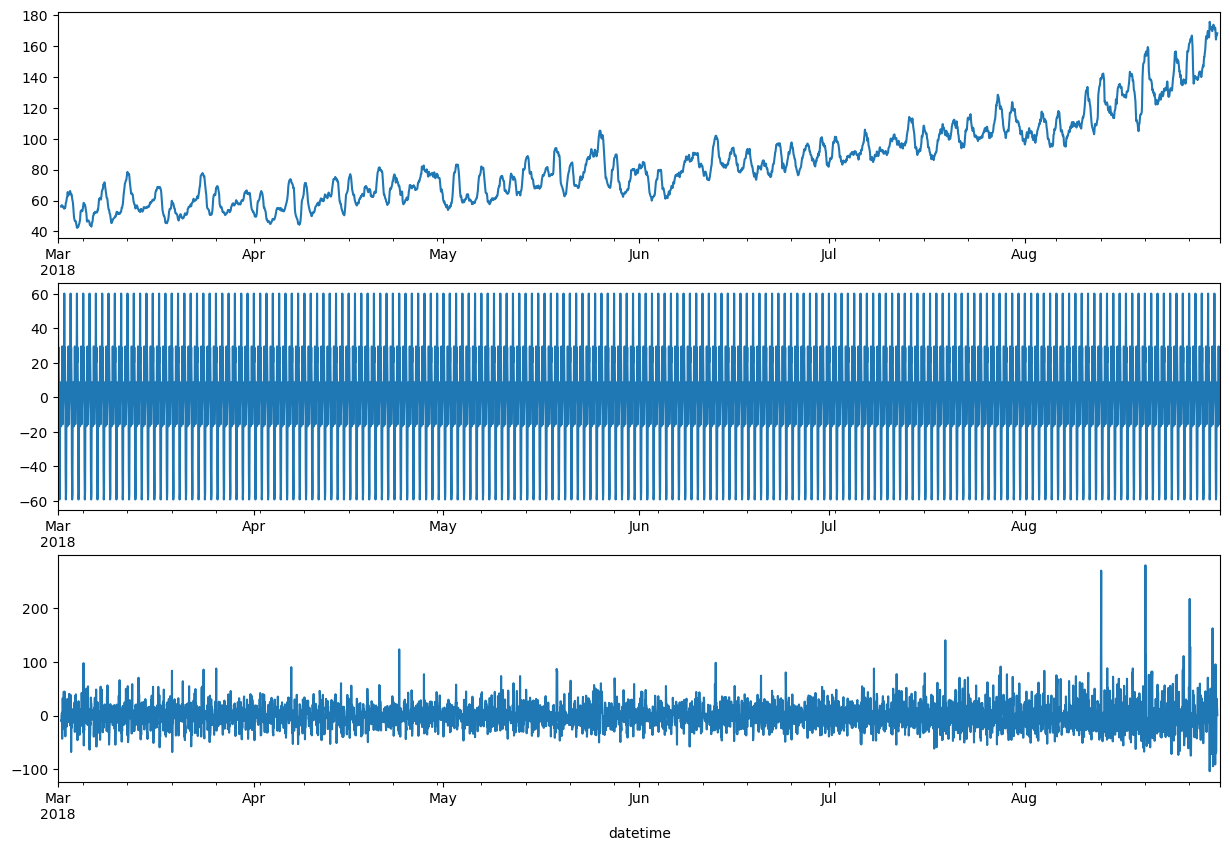

In [13]:
decomposed = seasonal_decompose(df)
fig, ax = plt.subplots(nrows=3, figsize=(15, 10))
decomposed.trend.plot(ax=ax[0])
decomposed.seasonal.plot(ax=ax[1])
decomposed.resid.plot(ax=ax[2]);

Увеличение числа заказов чётко заметно на линии тренда. Для анализа сезонности необходимо рассмотреть более узкий промежуток времени. На графике остатков заметны выбросы в сентябре.

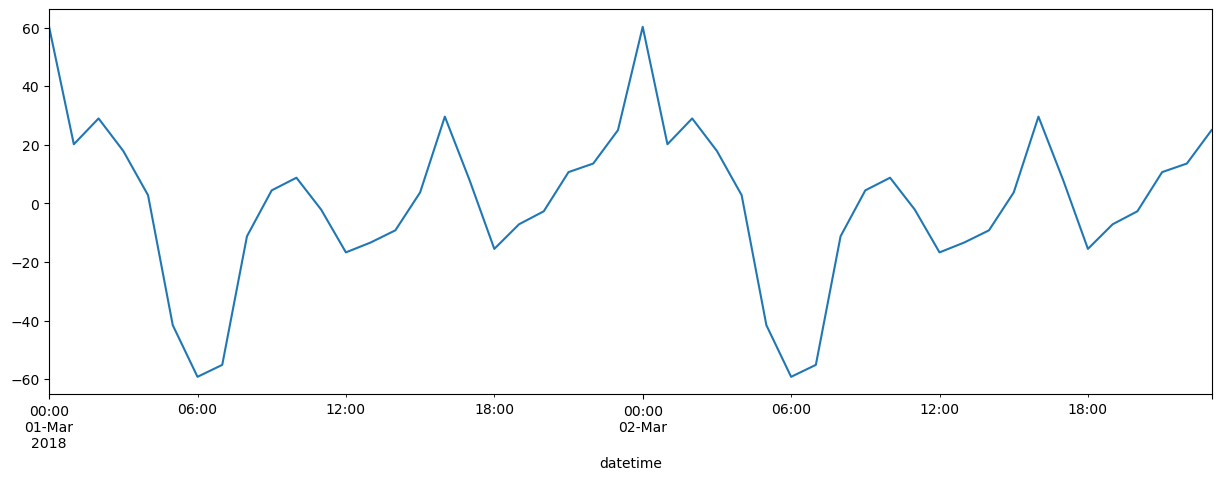

In [14]:
few_days_df = decomposed.seasonal['2018-03-01':'2018-03-02']
few_days_df.plot(figsize=(15, 5));

Наибольшее число заказов такси наблюдается около полуночи и 5 часов дня, минимум - с 5 до 7 утра

**Вывод по разделу 2:**
- Количество заказов такси постепенно увеличивается
- Наблюдаются ежедневные циклы, причём наибольшее число заказов такси наблюдается около полуночи и 5 часов дня, минимум - с 5 до 7 утра

## 3. <a id='toc3_'></a>[Обучение](#toc0_)

### 3.1. <a id='toc3_1_'></a>[Линейная регрессия](#toc0_)

Сначала попробуем использовать модель линейной регрессии. В пайплайн добавим также масштабирование данных.

Для подбора наилучших значений параметров `max_lag` и `rolling_mean_size` используем поиск по сетке, для кросс-валидации - `TimeSeriesSplit`.

In [15]:
linear_pipeline = Pipeline(steps=[
    ('features_maker', TimeSeriesFeaturesMaker(1, 1)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

ts_cv = TimeSeriesSplit(n_splits=4, gap=0)

params = {
    'features_maker__max_lag' : list(range(1, 8)),
    'features_maker__rolling_mean_size' : list(range(1, 10)),
    'scaler' : [StandardScaler(), None]
}

linear_grid = GridSearchCV(linear_pipeline, params,
                           scoring='neg_root_mean_squared_error', cv=ts_cv, verbose=1, n_jobs=-1)

In [16]:
%%time
linear_grid.fit(train, train);

Fitting 4 folds for each of 126 candidates, totalling 504 fits
CPU times: user 25.8 s, sys: 17.2 s, total: 42.9 s
Wall time: 43.1 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=Pipeline(steps=[('features_maker',
                                        TimeSeriesFeaturesMaker(rolling_mean_size=1)),
                                       ('scaler', StandardScaler()),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'features_maker__max_lag': [1, 2, 3, 4, 5, 6, 7],
                         'features_maker__rolling_mean_size': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9],
                         'scaler': [StandardScaler(), None]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [17]:
print('Значение RMSE, время обучения и время оценки при различных гиперпараметрах:')
print(pd.DataFrame(linear_grid.cv_results_)[['mean_test_score', 'mean_fit_time', 'mean_score_time']])
print('\nЛучшие гиперпараметры:\n', linear_grid.best_params_)
print('Лучшее значение RMSE:', -linear_grid.best_score_)

Значение RMSE, время обучения и время оценки и при различных гиперпараметрах:
     mean_test_score  mean_fit_time  mean_score_time
0         -31.857318       0.017231         0.024851
1         -31.862500       0.026311         0.010778
2         -31.875209       0.035341         0.010388
3         -31.875209       0.022586         0.022590
4         -31.904512       0.013719         0.035416
..               ...            ...              ...
121       -31.928827       0.140335         0.037450
122       -31.927935       0.182819         0.035551
123       -31.927935       0.107454         0.096185
124       -31.893483       0.168235         0.054702
125       -31.893483       0.165530         0.079250

[126 rows x 3 columns]

Лучшие гиперпараметры:
 {'features_maker__max_lag': 2, 'features_maker__rolling_mean_size': 4, 'scaler': StandardScaler()}
Лучшее значение RMSE: 31.72793755989536


Линейная регрессия даёт наилучший результат при `max_lag` = 2 и `rolling_mean_size` = 4. При этом RMSE = 31.72

### 3.2. <a id='toc3_2_'></a>[Решающее дерево](#toc0_)

Теперь обучим модель решающего дерева. Для подбора гиперпараметров используем поиск по сетке.

In [18]:
tree_pipeline = Pipeline(steps=[
    ('features_maker', TimeSeriesFeaturesMaker(1, 1)),
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=42))
])

params = {
    'features_maker__max_lag' : list(range(1, 8, 2)),
    'features_maker__rolling_mean_size' : list(range(1, 5)),
    'scaler' : [StandardScaler(), None],
    'model__max_depth' : list(range(4, 15, 3)),
    'model__min_samples_split' : list(range(8, 20, 4)),
    'model__min_samples_leaf' : list(range(8, 20, 4))
}

tree_grid = GridSearchCV(tree_pipeline, param_grid=params,
                         scoring='neg_root_mean_squared_error', cv=ts_cv, verbose=1, n_jobs=-1)

In [19]:
%%time
tree_grid.fit(train, train);

Fitting 4 folds for each of 1152 candidates, totalling 4608 fits
CPU times: user 2min 20s, sys: 692 ms, total: 2min 20s
Wall time: 2min 20s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=Pipeline(steps=[('features_maker',
                                        TimeSeriesFeaturesMaker(rolling_mean_size=1)),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'features_maker__max_lag': [1, 3, 5, 7],
                         'features_maker__rolling_mean_size': [1, 2, 3, 4],
                         'model__max_depth': [4, 7, 10, 13],
                         'model__min_samples_leaf': [8, 12, 16],
                         'model__min_samples_split': [8, 12, 16],
                         'scaler': [StandardScaler(), None]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [20]:
print('Значение RMSE, время обучения и время оценки при различных гиперпараметрах:')
print(pd.DataFrame(tree_grid.cv_results_)[['mean_test_score', 'mean_fit_time', 'mean_score_time']])
print('\nЛучшие гиперпараметры:\n', tree_grid.best_params_)
print('Лучшее значение RMSE:', -tree_grid.best_score_)

Значение RMSE, время обучения и время оценки и при различных гиперпараметрах:
      mean_test_score  mean_fit_time  mean_score_time
0          -32.225776       0.016842         0.021214
1          -32.225776       0.016193         0.009952
2          -32.225776       0.015763         0.010452
3          -32.225776       0.013750         0.009692
4          -32.225776       0.014762         0.009851
...               ...            ...              ...
1147       -29.280138       0.021443         0.012900
1148       -29.306627       0.023625         0.012406
1149       -29.280138       0.020689         0.012104
1150       -29.306627       0.022329         0.011892
1151       -29.280138       0.022912         0.012981

[1152 rows x 3 columns]

Лучшие гиперпараметры:
 {'features_maker__max_lag': 1, 'features_maker__rolling_mean_size': 4, 'model__max_depth': 10, 'model__min_samples_leaf': 12, 'model__min_samples_split': 8, 'scaler': StandardScaler()}
Лучшее значение RMSE: 27.53637675484369

Решающее дерево показыает себя лучше линейной регрессии: RMSE = 27.53 при оптимальных гиперпараметрах.

### 3.3. <a id='toc3_3_'></a>[Случайный лес](#toc0_)

Теперь обучим случайный лес. Вместо обычного поиска по сетке используем HalvingGridSearchCV, выбрав в качестве ресурса колиество деревьев.

In [21]:
rf_pipeline = Pipeline(steps=[
    ('features_maker', TimeSeriesFeaturesMaker(1, 1)),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

params = {
    'features_maker__max_lag' : [1, 2],
    'features_maker__rolling_mean_size' : [3, 4, 5],
    'model__max_depth' : [8, 10, 12],
    'model__min_samples_split' : [8, 10],
    'model__min_samples_leaf' : [12, 15]
}

rf_grid  = HalvingGridSearchCV(rf_pipeline, params, scoring='neg_root_mean_squared_error',
                                  cv=ts_cv, verbose=3, n_jobs=-1, max_resources=250, factor=3,
                                  resource='model__n_estimators')

In [22]:
%%time
rf_grid.fit(train, train.values.ravel());

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 9
max_resources_: 250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 9
Fitting 4 folds for each of 72 candidates, totalling 288 fits
[CV 1/4] END features_maker__max_lag=1, features_maker__rolling_mean_size=3, model__max_depth=8, model__min_samples_leaf=12, model__min_samples_split=8, model__n_estimators=9; total time=   0.1s
[CV 2/4] END features_maker__max_lag=1, features_maker__rolling_mean_size=3, model__max_depth=8, model__min_samples_leaf=12, model__min_samples_split=8, model__n_estimators=9; total time=   0.1s
[CV 3/4] END features_maker__max_lag=1, features_maker__rolling_mean_size=3, model__max_depth=8, model__min_samples_leaf=12, model__min_samples_split=8, model__n_estimators=9; total time=   0.1s
[CV 4/4] END features_maker__max_lag=1, features_maker__rolling_mean_size=3, model__max_depth=8, model__min_samples_leaf=12, model__min_samples_split=8, model

HalvingGridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                    estimator=Pipeline(steps=[('features_maker',
                                               TimeSeriesFeaturesMaker(rolling_mean_size=1)),
                                              ('scaler', StandardScaler()),
                                              ('model',
                                               RandomForestRegressor(random_state=42))]),
                    max_resources=250, n_jobs=-1,
                    param_grid={'features_maker__max_lag': [1, 2],
                                'features_maker__rolling_mean_size': [3, 4, 5],
                                'model__max_depth': [8, 10, 12],
                                'model__min_samples_leaf': [12, 15],
                                'model__min_samples_split': [8, 10]},
                    refit=<function _refit_callable at 0x7faf5a5bfdc0>,
                    resource='model__n_estimators'

In [23]:
params_names = ['n_resources', 'param_features_maker__max_lag', 'param_features_maker__rolling_mean_size',
                'param_model__max_depth','param_model__min_samples_split', 'param_model__min_samples_leaf']

res = pd.DataFrame(rf_grid.cv_results_)[['mean_fit_time', 'mean_score_time', 'mean_test_score', *params_names]]
best_res = res[res.mean_test_score == res.mean_test_score.max()].iloc[0]

print('Лучшая модель')
print('RMSE:', -float(best_res['mean_test_score']))
display('Гиперпараметры:', best_res[params_names])
display('Время обучения и время предсказания:', best_res[['mean_fit_time', 'mean_score_time']])

Лучшая модель
RMSE: 26.582666333453197


'Гиперпараметры:'

n_resources                                27
param_features_maker__max_lag               2
param_features_maker__rolling_mean_size     5
param_model__max_depth                     12
param_model__min_samples_split              8
param_model__min_samples_leaf              12
Name: 94, dtype: object

'Время обучения и время предсказания:'

mean_fit_time      0.111424
mean_score_time    0.013299
Name: 94, dtype: object

Лучший результат здесь даёт лес, в котором 27 деревьев. При этом значение целевой метрики уменьшается лишь незначительно: до 26.58. Время обучения составляет 0.1 сек, время предсказания - 0.01 сек.

### 3.4. <a id='toc3_4_'></a>[Градиентный бустинг](#toc0_)

Следующая модель - градиентный бустинг (библиотека LigthGBM)

In [24]:
lgbm_pipeline = Pipeline(steps=[
    ('features_maker', TimeSeriesFeaturesMaker(1, 1)),
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor(random_state=42))
])

params = {
    'features_maker__max_lag' : [1, 2],
    'features_maker__rolling_mean_size' : [5, 6],
    "model__max_depth": [12, 14],
    "model__boosting_type" : ['gbdt'],
    "model__min_child_samples" : [12, 20],
    "model__learning_rate" : [0.1, 0.3, 0.5],
    "model__num_leaves": [31, 70]
}

lgbm_grid  = HalvingGridSearchCV(lgbm_pipeline, params, scoring='neg_root_mean_squared_error',
                                  cv=ts_cv, verbose=3, n_jobs=-1, max_resources=150, factor=3,
                                  resource='model__n_estimators')

In [25]:
%%time
lgbm_grid.fit(train, train.values.ravel());

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1
max_resources_: 150
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 96
n_resources: 1
Fitting 4 folds for each of 96 candidates, totalling 384 fits
[CV 1/4] END features_maker__max_lag=1, features_maker__rolling_mean_size=5, model__boosting_type=gbdt, model__learning_rate=0.1, model__max_depth=12, model__min_child_samples=12, model__n_estimators=1, model__num_leaves=31; total time=   2.8s
[CV 2/4] END features_maker__max_lag=1, features_maker__rolling_mean_size=5, model__boosting_type=gbdt, model__learning_rate=0.1, model__max_depth=12, model__min_child_samples=12, model__n_estimators=1, model__num_leaves=31; total time=   3.9s
[CV 3/4] END features_maker__max_lag=1, features_maker__rolling_mean_size=5, model__boosting_type=gbdt, model__learning_rate=0.1, model__max_depth=12, model__min_child_samples=12, model__n_estimators=1, model__num_leaves=31; total time=   3.1s
[CV 4/4] EN

HalvingGridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                    estimator=Pipeline(steps=[('features_maker',
                                               TimeSeriesFeaturesMaker(rolling_mean_size=1)),
                                              ('scaler', StandardScaler()),
                                              ('model',
                                               LGBMRegressor(random_state=42))]),
                    max_resources=150, n_jobs=-1,
                    param_grid={'features_maker__max_lag': [1, 2],
                                'features_maker__rolling_mean_size': [5, 6],
                                'model__boosting_type': ['gbdt'],
                                'model__learning_rate': [0.1, 0.3, 0.5],
                                'model__max_depth': [12, 14],
                                'model__min_child_samples': [12, 20],
                                'model__num_leaves': [31, 70]},
  

In [26]:
params_names = ['n_resources', 'param_features_maker__max_lag', 'param_features_maker__rolling_mean_size',
                'param_model__max_depth', 'param_model__min_child_samples', 'param_model__num_leaves',
                'param_model__learning_rate']

res = pd.DataFrame(lgbm_grid.cv_results_)[['mean_fit_time', 'mean_score_time', 'mean_test_score', *params_names]]
best_res = res[res.mean_test_score == res.mean_test_score.max()]

print('Лучшая модель')
print('RMSE:', -float(best_res['mean_test_score']))
display('Гиперпараметры:', best_res[params_names])
display('Время обучения и время предсказания:', best_res[['mean_fit_time', 'mean_score_time']])

Лучшая модель
RMSE: 26.2755683822141


'Гиперпараметры:'

,n_resources,param_features_maker__max_lag,param_features_maker__rolling_mean_size,param_model__max_depth,param_model__min_child_samples,param_model__num_leaves,param_model__learning_rate
138,9,1,6,14,20,70,0.5


'Время обучения и время предсказания:'

,mean_fit_time,mean_score_time
138,42.272798,0.075954


Лучшее значение RMSE модели градиентного бустинга составляет 26.2. Этот результат лучше, чем у случайного леса.

**Вывод по разделу 3:**
- Обучены 4 различные модели: линейная регрессия, дерево решений, случайный лес и градиентный бустинг (LightGBM)
- Наименьшее значение метрики RMSE (26.2) позволяет получить **градиентный бустинг**
- *Время обучения* модели - 42 сек, *время предсказания* - 0.07 сек
- Гиперпараметры лучшей модели: `n_estimators` = 9, `max_lag` = 1, `rolling_mean_size` = 6, `max_depth` = 14, `min_child_samples` = 20, `num_leaves` = 70, `learning_rate` = 0.5

## 4. <a id='toc4_'></a>[Тестирование](#toc0_)

Теперь проверим качество модели. Для этого обучим её на всей обучающей выборке и найдём значение RMSE на тестовой. 

In [27]:
%%time
best_pipeline = Pipeline(steps=[
    ('features_maker', TimeSeriesFeaturesMaker(max_lag=1, rolling_mean_size=6)),
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor(max_depth=14, min_child_samples=20, n_estimators=9,
                            num_leaves=70, learning_rate=0.5, random_state=42))
])

best_pipeline.fit(train, train.values.ravel())
predictions = best_pipeline.predict(test)
print('RMSE = ', mse(test, predictions)**0.5)

RMSE =  43.03315799374797
CPU times: user 7.86 s, sys: 129 ms, total: 7.99 s
Wall time: 8 s


Значение RMSE на тестовой выборке: 43.03

Теперь рассмотрим какие признаки оказались наиболее важными при обучении моделей

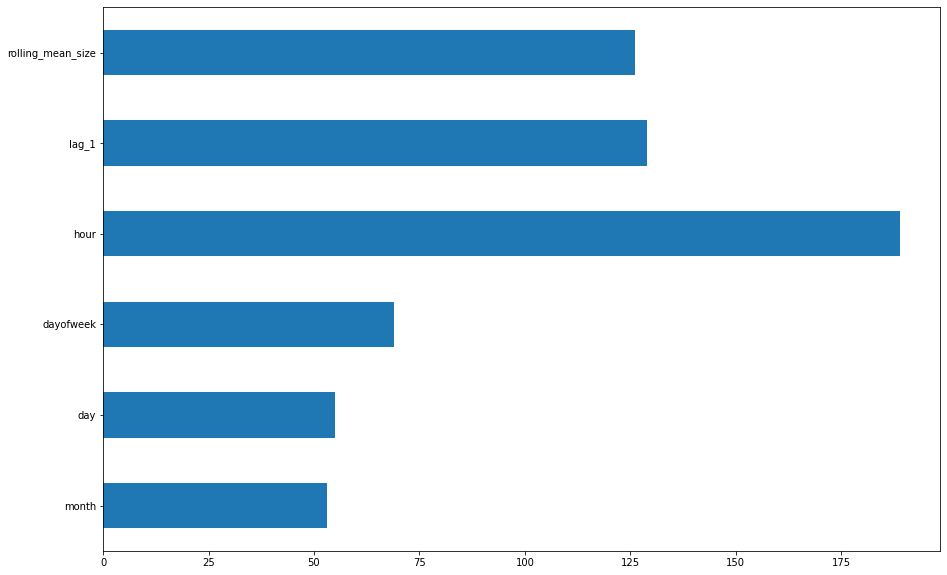

In [28]:
cols = ['month', 'day', 'dayofweek', 'hour', 'lag_1', 'rolling_mean_size']
pd.Series(best_pipeline.named_steps['model'].feature_importances_, index=cols)\
            .plot(kind='barh', figsize=(15, 10));

Наиболее важные признаки - час, первый лаг и скользящее среднее за 6 часов. Остальные - менее важны

Визуализируем финальные предсказания: графики исходного и предсказанных рядов.

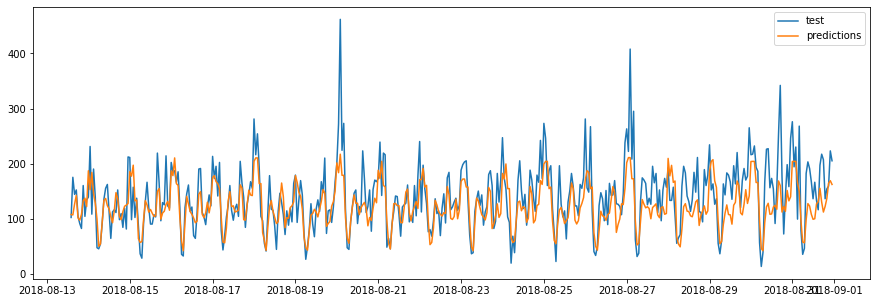

In [37]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test.index, test.values, test.index, predictions);
plt.legend(['test', 'predictions']);

## 5. <a id='toc5_'></a>[Общий вывод](#toc0_)

- Проведён ресемплинг данных по одному часу; созданы признаки временного ряда
- Проведён анализ датасета: количество заказов такси увеличивается; наблюдаются ежедневные циклы, наибольшее число заказов - около полуночи и 5 часов дня, минимум - с 5 до 7 утра
- Обучены 4 различные модели: линейная регрессия, дерево решений, случайный лес и градиентный бустинг (LightGBM)
- Лучшей моделью выбран **градиентный бустинг**: *время обучения* модели - 42.2 сек, *время предсказания* - 0.07 сек
- Значение метрики RMSE на тестовой выборке 43.03
- Наиболее важные признаки - час, первый лаг и скользящее среднее за 6 часов. Остальные - менее важны

## 6. <a id='toc6_'></a>[Чек-лист проверки](#toc0_)

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48